# Anomaly detection in an IoT setting (spotlight: Stream processing)

This notebook covers the entire project workflow for anomaly detection in in the production cycle 
and a faulty produced item using IoT sensor data. 
We'll explore the data, train multiple models, compare their performance, and demonstrate integration with the prediction API.

## System Architecture Overview

To clearly understand and communicate the flow of data and processes in this IoT anomaly detection project, I decided to generate the architecture diagrams **programmatically** using Python scripts. Honestly, I'm a bit bored of online drag-and-drop tools—so I found [diagrams](https://diagrams.mingrammer.com/) and [graphviz](https://graphviz.gitlab.io/) to be much more flexible and reproducible for this purpose.

---

### 1. Local Architecture

The **local pipeline** starts with IoT data ingestion (simulated locally), followed by data processing (normalization/scaling), then feeds the data into an ML model (Isolation Forest). Predictions are served via a FastAPI endpoint, with results and logs stored locally. Monitoring and logging are also included for metrics and errors.

![Local IoT Anomaly Detection Pipeline](Scripts/local_iot_anomaly_detection_pipeline.png)

---

### 2. Cloud Architecture (Azure)

To scale up, the **cloud architecture** moves the components into a Docker container, deployed on Azure. Data is ingested and stored in Azure Blob Storage, processed and scaled in the container, and predictions are served via a web API. Azure Monitor handles observability, and the client dashboard accesses results remotely.

![Cloud IoT Anomaly Detection Architecture (Azure)](Scripts/cloud_iot_anomaly_detection_architecture_(azure).png)

---

By generating these diagrams with code, I ensure the architecture is always up-to-date and easy to modify as the project evolves.

## Data Loading and Exploration

Let's load the smart manufacturing dataset and explore its structure and characteristics.

In [2]:

import pandas as pd


data_path = 'Data/data.csv'
data = pd.read_csv(data_path)

print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nData types:")
print(data.dtypes)

print("\nSummary statistics:")
print(data.describe())

print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (100000, 13)

First 5 rows:
             timestamp  machine_id  temperature  vibration  humidity  \
0  2025-01-01 00:00:00          39        78.61      28.65     79.96   
1  2025-01-01 00:01:00          29        68.19      57.28     35.94   
2  2025-01-01 00:02:00          15        98.94      50.20     72.06   
3  2025-01-01 00:03:00          43        90.91      37.65     30.34   
4  2025-01-01 00:04:00           8        72.32      40.69     56.71   

   pressure  energy_consumption  machine_status  anomaly_flag  \
0      3.73                2.16               1             0   
1      3.64                0.69               1             0   
2      1.00                2.49               1             1   
3      3.15                4.96               1             1   
4      2.68                0.63               2             0   

   predicted_remaining_life     failure_type  downtime_risk  \
0                       106           Normal            0.0   
1      

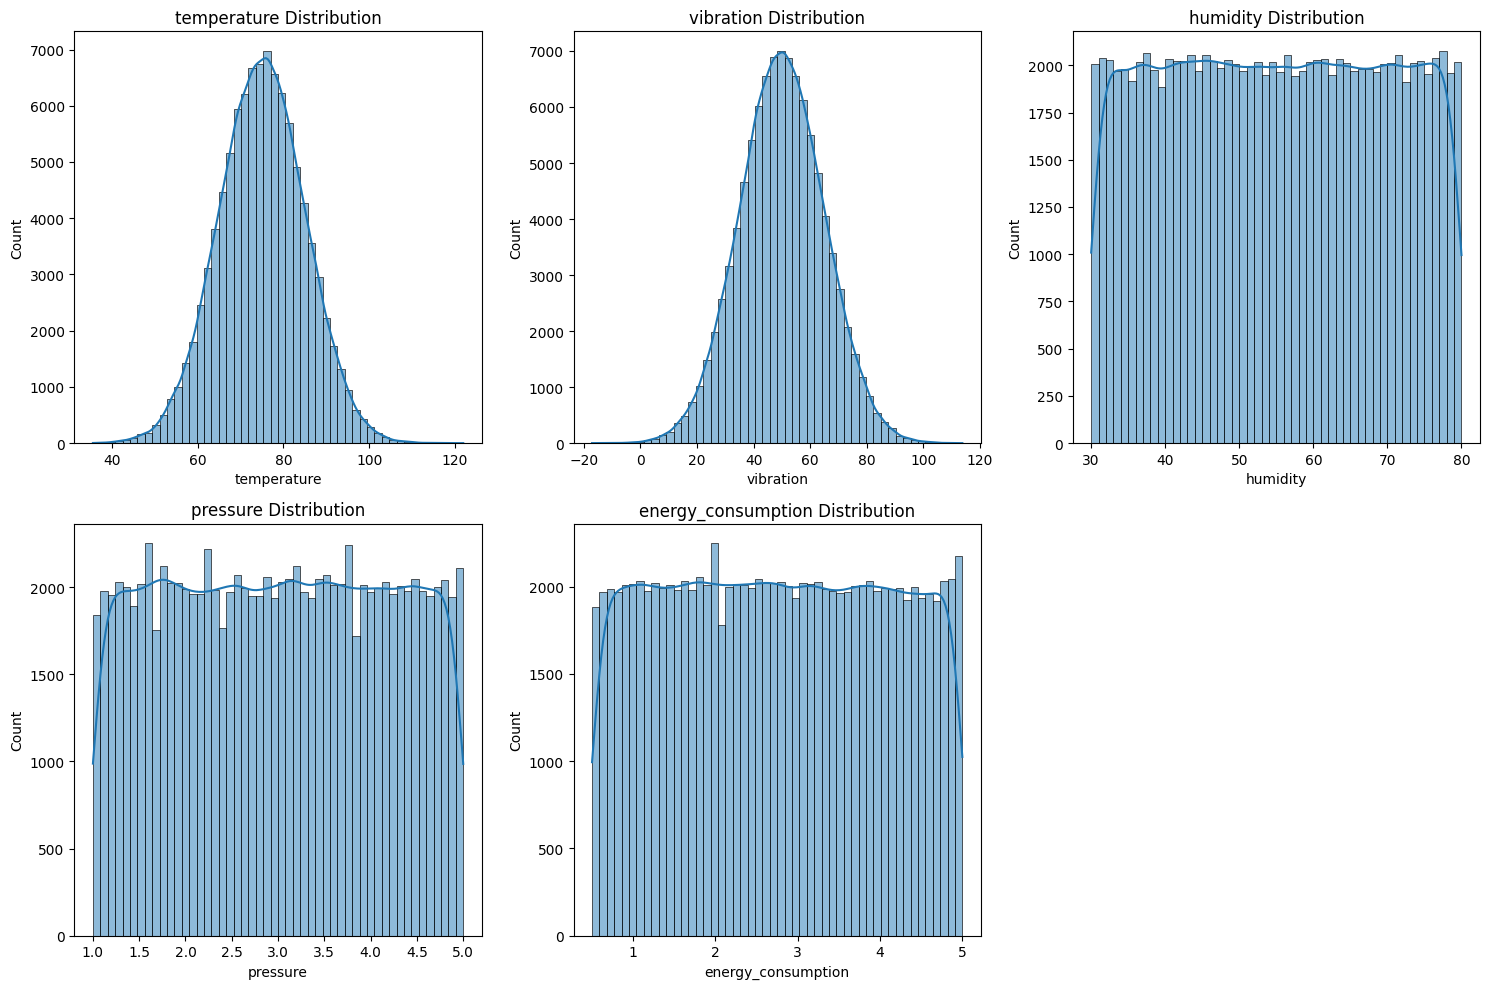

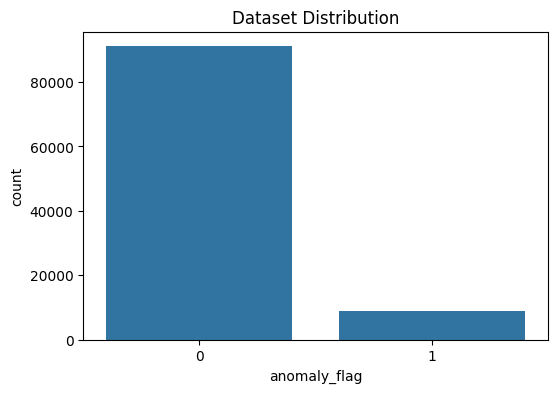

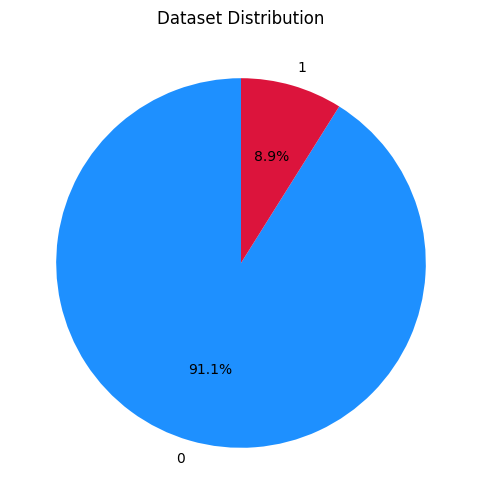

Anomaly ratio: 0.08916
anomaly_flag
0    91084
1     8916
Name: count, dtype: int64
anomaly_flag
0    91.084
1     8.916
Name: proportion, dtype: float64


In [6]:
# Visualize data distributions
from matplotlib import pyplot as plt
import seaborn as sns
features = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], bins=50, kde=True)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

# Check anomaly distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='anomaly_flag', data=data)
plt.title('Dataset Distribution')
plt.show()

# anomaly distribution in pie chart :
plt.figure(figsize=(6, 6))
data['anomaly_flag'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['dodgerblue', 'crimson'])
plt.title('Dataset Distribution')
plt.ylabel('')
plt.savefig('Output/anomaly_distribution_pie_chart.png')
plt.show()


print("Anomaly ratio:", data['anomaly_flag'].mean())
# Number of anomalies vs normal instances
print(data['anomaly_flag'].value_counts())
# Number of anomalies vs normal instances in percentages
print(data['anomaly_flag'].value_counts(normalize=True) * 100)



### About The dataset
**Dataset Source** : [Kaggle - Smart Manufacturing IoT-Cloud Monitoring Dataset](https://www.kaggle.com/datasets/ziya07/smart-manufacturing-iot-cloud-monitoring-dataset)

- **Dataset Shape**: 100,000 rows and 13 columns of IoT sensor data.
- **Columns**:
  - `timestamp`: Date and time of the sensor reading.
  - `machine_id`: Unique identifier for each machine.
  - `temperature`: Temperature reading from the sensor.
  - `vibration`: Vibration level from the sensor.
  - `humidity`: Humidity level from the sensor.
  - `pressure`: Pressure reading from the sensor.
  - `energy_consumption`: Energy consumption at the time of reading.
  - `machine_status`: Current status of the machine (0 = off, 1 = on).
  - `anomaly_flag`: Binary indicator (0 = normal, 1 = anomaly).
  - `predicted_remaining_life`: Predicted remaining life of the equipment.
  - `failure_type`: Type of failure (if any) associated with the reading.
  - `downtime_risk`: Risk score for potential downtime.
  - `maintenance_required`: Indicator (0 = no, 1 = yes) for maintenance needs.
- **Data Types**: Mixed (numeric, categorical, datetime).
- **Missing Values**: None - all data is complete.
- **Anomaly Ratio**: 8.92% of data points are anomalies (8,916 out of 100,000).
- **Value Counts**: 91,084 normal instances (91.08%), 8,916 anomalies (8.92%).

## Data Preprocessing

We'll select relevant features and normalize the data for model training.

In [7]:

import joblib
from sklearn.discriminant_analysis import StandardScaler

# I started by training the model using all features , then everytime I check the feature importance , remove the less important ones and retrain the model to get the best results.

selected_features = ['temperature', 'vibration', 'humidity', 'energy_consumption', 'predicted_remaining_life', 'downtime_risk']
X = data[selected_features] 

print("Selected features shape:", X.shape)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# To make sure normalization worked, I checked that the means are close to 0 and stds close to 1
# print("Data normalized. Mean:", X_scaled.mean(axis=0))
# print("Data normalized. Std:", X_scaled.std(axis=0))

# Save scaler for later use
joblib.dump(scaler, 'models/scaler.pkl')
print("Scaler saved to models/scaler.pkl")

Selected features shape: (100000, 6)
Scaler saved to models/scaler.pkl


This code prepares the data for machine learning models:

1. **Feature Selection**: I picked 6 important features from the dataset (temperature, vibration, humidity, energy_consumption, predicted_remaining_life, downtime_risk) that are most relevant for detecting anomalies.

2. **Data Normalization**: I used StandardScaler to standardize the features . This makes all features have the same scale (mean=0, std=1), which helps the models work better.

3. **Saving the Scaler**: I saved the scaler to a file so we can use it later to transform new data in the same way for predictions.

The output shows the shape of selected data (100k rows, 6 columns), and confirms the normalization worked (means are ~0, stds are ~1). The scaler is saved for future use in the API.

## Model Training

We'll train three different anomaly detection models:
1. Isolation Forest
2. One-Class SVM
3. Local Outlier Factor

In [8]:
# Train Isolation Forest
from sklearn.ensemble import IsolationForest


iso_forest = IsolationForest(contamination=0.08916, random_state=42, n_estimators=200)
iso_forest.fit(X_scaled)

# Save the model
joblib.dump(iso_forest, 'models/anomaly_model.pkl')
print("Isolation Forest model trained and saved.")

Isolation Forest model trained and saved.


In [9]:
# Train One-Class SVM
from sklearn.svm import OneClassSVM


oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.08916)
oc_svm.fit(X_scaled)
print("One-Class SVM model trained.")

One-Class SVM model trained.


In [10]:
# Train Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.08916, novelty=True)
lof.fit(X_scaled)
print("Local Outlier Factor model trained.")

Local Outlier Factor model trained.


## Models Evaluation

Let's evaluate each model using the Actual "anomaly_flag" labels and calculate performance metrics.


Isolation Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91084
           1       0.95      0.95      0.95      8916

    accuracy                           0.99    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.99      0.99      0.99    100000



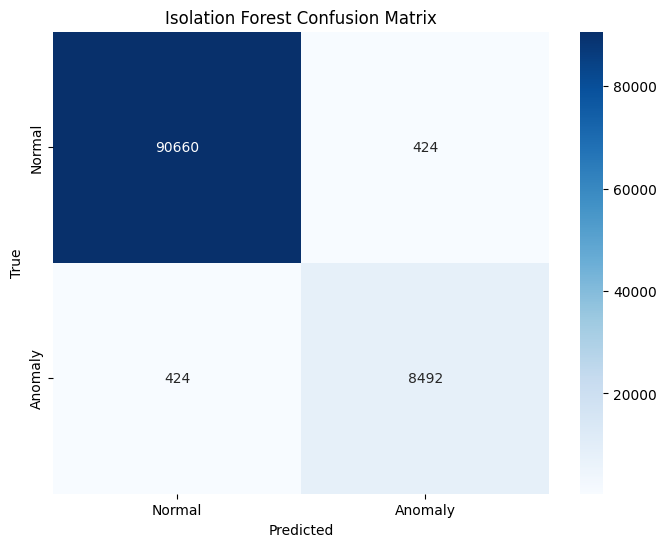


One-Class SVM Performance:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     91084
           1       0.35      0.35      0.35      8916

    accuracy                           0.88    100000
   macro avg       0.64      0.64      0.64    100000
weighted avg       0.88      0.88      0.88    100000



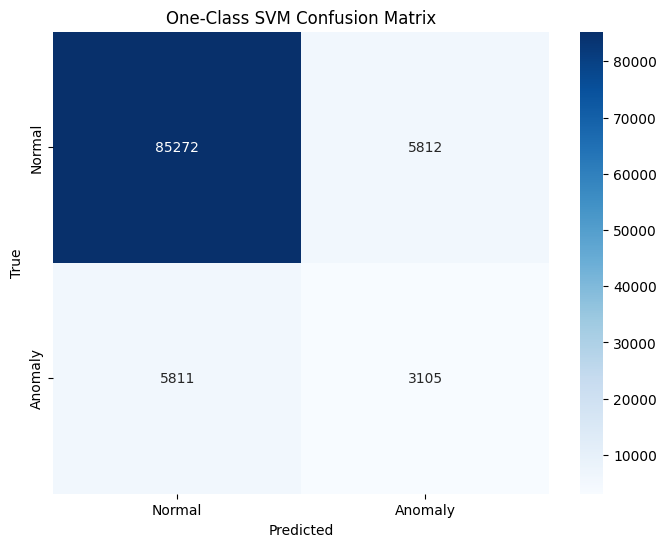


Local Outlier Factor Performance:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     91084
           1       0.20      0.17      0.19      8916

    accuracy                           0.86    100000
   macro avg       0.56      0.55      0.56    100000
weighted avg       0.86      0.86      0.86    100000



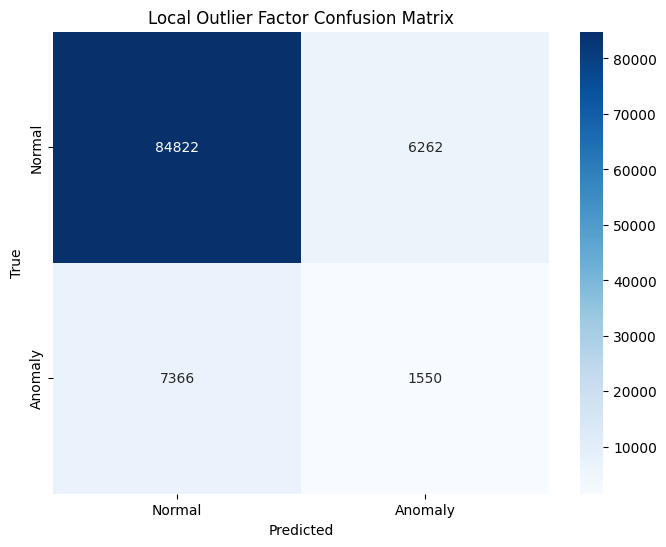

In [11]:
# Get predictions from each model
from sklearn.metrics import classification_report, confusion_matrix


iso_predictions = iso_forest.predict(X_scaled)
oc_svm_predictions = oc_svm.predict(X_scaled)
lof_predictions = lof.predict(X_scaled)

# Convert predictions: -1 (anomaly) to 1, 1 (normal) to 0 for consistency with anomaly_flag
iso_predictions_binary = (iso_predictions == -1).astype(int)
oc_svm_predictions_binary = (oc_svm_predictions == -1).astype(int)
lof_predictions_binary = (lof_predictions == -1).astype(int)

# Actual "anomaly_flag" labels to compare with : 
y_true = data['anomaly_flag'].values

# Evaluate each model
models = ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor']
predictions = [iso_predictions_binary, oc_svm_predictions_binary, lof_predictions_binary]
for model_name, pred in zip(models, predictions):
    print(f"\n{model_name} Performance:")
    print(classification_report(y_true, pred))
    cm = confusion_matrix(y_true, pred)
    # Show & Save confusion matrix Figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f'Output/{model_name.replace(" ", "_").lower()}_confusion_matrix.png')
    plt.show()

### Model Evaluation Results

### Isolation Forest
- **Performance**: Excellent! 99% accuracy overall. Perfect at detecting normal operations (100% precision/recall), and very good at spotting anomalies (95% precision and recall).
- **Confusion Matrix**: Shows almost no mistakes - very few false positives (normals wrongly flagged as anomalies) or false negatives (anomalies missed). It's like a perfect detective.

### One-Class SVM
- **Performance**: Decent for normals (94% precision/recall), but struggles with anomalies - only 35% precision and recall. Overall accuracy 88%.
- **Confusion Matrix**: Good at identifying normal data, but misses many anomalies and incorrectly flags many normals as anomalies.

### Local Outlier Factor
- **Performance**: Okay for normals (92-93% precision/recall), but poor for anomalies - only 17-20% precision and recall. Overall accuracy 86%.
- **Confusion Matrix**: Catches most normals correctly, but misses most anomalies and has many false alarms.

> **💡Note** Here the accuracy isn't as important as the F1 score, especially in imbalanced datasets like this one. The F1 score considers both precision and recall, providing a better measure of a model's performance on rare events like anomalies.

## Models Comparison

Let's compare the models visually and select the best performing one.

Isolation Forest F1-Score: 0.9524
One-Class SVM F1-Score: 0.3482
Local Outlier Factor F1-Score: 0.1853


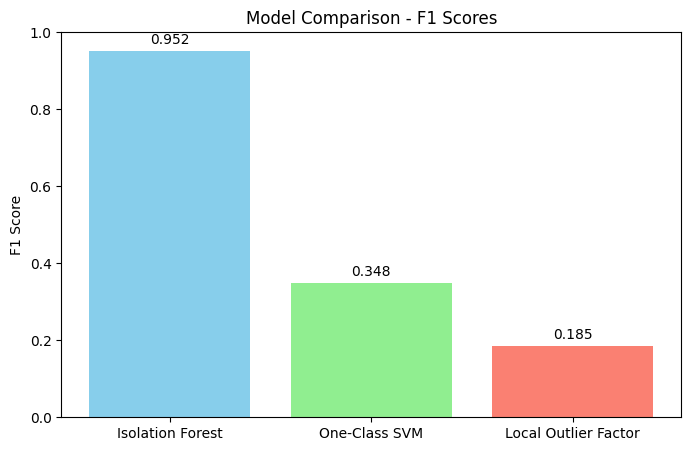


Best performing model: Isolation Forest with F1-score: 0.9524


In [12]:
# Calculate F1-scores for comparison
import numpy as np
from sklearn.metrics import f1_score

f1_scores = []
for model_name, pred in zip(models, predictions):
    f1 = f1_score(y_true, pred)
    f1_scores.append(f1)
    print(f"{model_name} F1-Score: {f1:.4f}")

# Plot comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(models, f1_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison - F1 Scores')
plt.ylabel('F1 Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')
plt.savefig('Output/model_comparison_f1_scores.png')
plt.show()

# Select best model
best_model_idx = np.argmax(f1_scores)
best_model = models[best_model_idx]
print(f"\nBest performing model: {best_model} with F1-score: {f1_scores[best_model_idx]:.4f}")

## Predictions and Analysis

Let's generate predictions using the best model and analyze the results.

Predictions saved to Output/predictions.csv


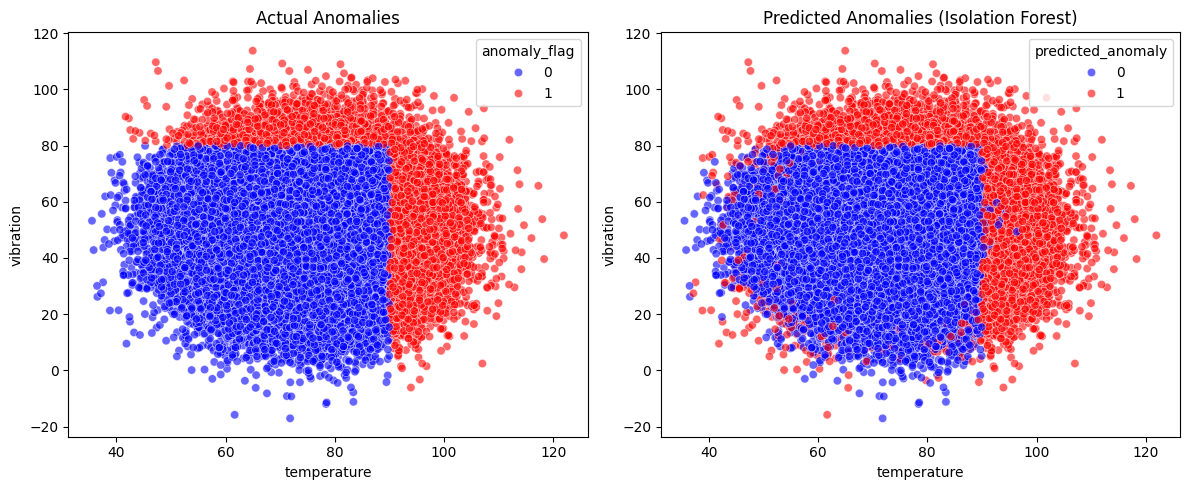

Total anomalies detected: 8916
Actual anomalies: 8916


In [13]:
# Use the best model for final predictions
if best_model == 'Isolation Forest':
    final_model = iso_forest
    final_predictions = iso_predictions_binary
elif best_model == 'One-Class SVM':
    final_model = oc_svm
    final_predictions = oc_svm_predictions_binary
else:
    final_model = lof
    final_predictions = lof_predictions_binary

# Add predictions to dataframe
data['predicted_anomaly'] = final_predictions

# Save predictions
data.to_csv('Output/predictions.csv', index=False)
print("Predictions saved to Output/predictions.csv")

# Visualize anomaly distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='temperature', y='vibration', hue='anomaly_flag', 
                palette=['blue', 'red'], alpha=0.6)
plt.title('Actual Anomalies')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='temperature', y='vibration', hue='predicted_anomaly', 
                palette=['blue', 'red'], alpha=0.6)
plt.title(f'Predicted Anomalies ({best_model})')

plt.tight_layout()
plt.savefig('Output/anomaly_detection_comparison.png')
plt.show()

print(f"Total anomalies detected: {sum(final_predictions)}")
print(f"Actual anomalies: {sum(y_true)}")


**Left Plot (Actual Anomalies)**: Real data points from the sensors, colored blue for normal operations and red for actual anomalies. It shows where the true problems occurred.

**Right Plot (Predicted Anomalies)**: What the Isolation Forest model predicted, using the same colors. Blue dots are predicted normal, red dots are predicted anomalies.

Both plots use temperature on the x-axis and vibration on the y-axis. The model does a good job matching the actual anomalies (red dots cluster similarly), though there might be a few mismatches where the model got it wrong but overall it captures the anomaly patterns well.

## Feature Importance Analysis

The first training using just the three features: temperature, vibration, and humidity give us an F1 score of  46% , then I decided to test training with 10 features I got a increase in F1 score to 65 % . Then I decided to code the next section to check the feature importance using the Isolation Forest model.
Every time I check what are the important feature , change the features and retrain the model till I got the best F1 score 95.24% using the current 6 features.

Feature Importances (Mutual Information):
                    feature  mutual_info
5             downtime_risk     0.307440
4  predicted_remaining_life     0.198478
0               temperature     0.197851
1                 vibration     0.057795
2                  humidity     0.001283
3        energy_consumption     0.001202


C:\Users\user\AppData\Local\Temp\ipykernel_11500\276815068.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mutual_info', y='feature', data=importance_df, palette='viridis')


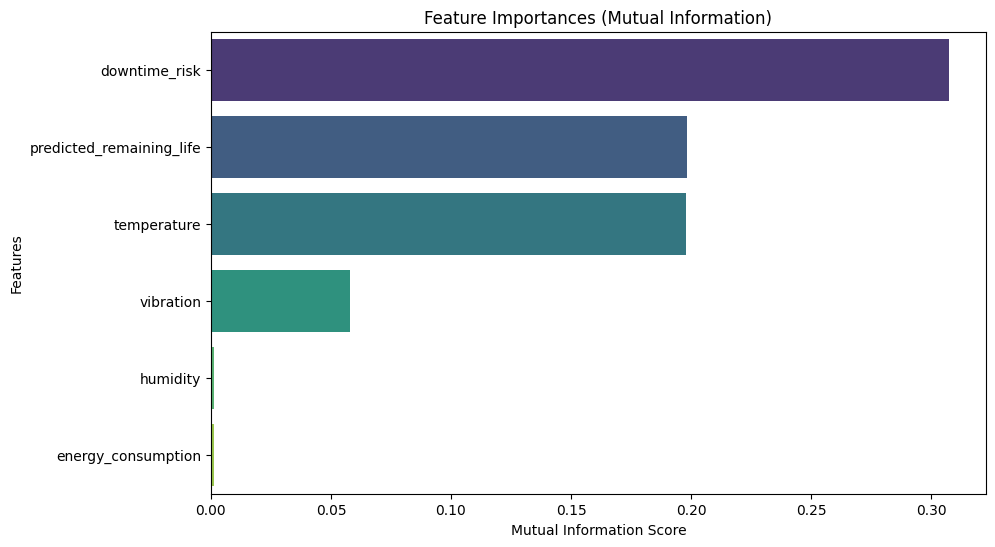


Correlation with anomaly_flag (absolute values):
downtime_risk               0.999998
temperature                 0.446987
predicted_remaining_life    0.436342
vibration                   0.177386
energy_consumption          0.005737
humidity                    0.000644
Name: anomaly_flag, dtype: float64


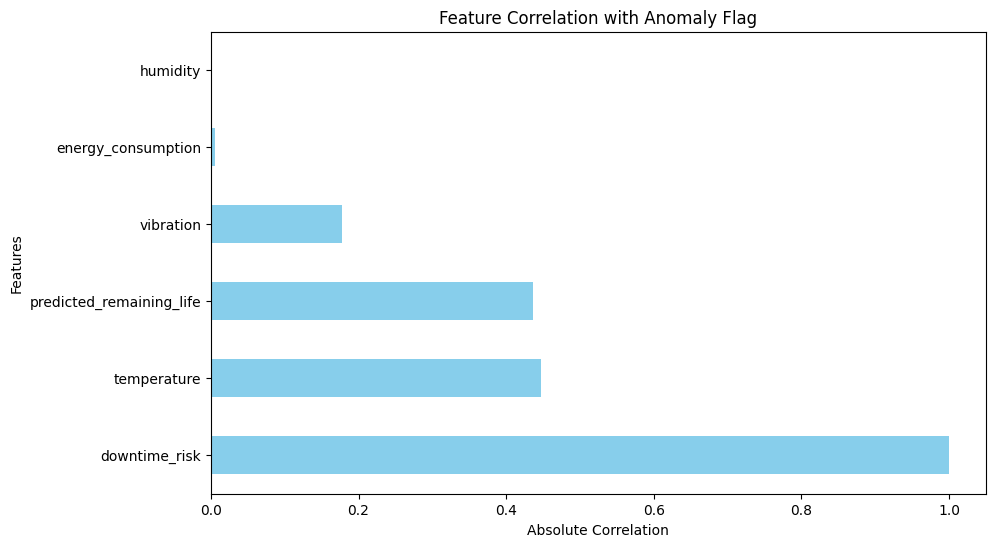


Top 5 most important features (by mutual information): ['downtime_risk', 'predicted_remaining_life', 'temperature', 'vibration', 'humidity', 'energy_consumption']


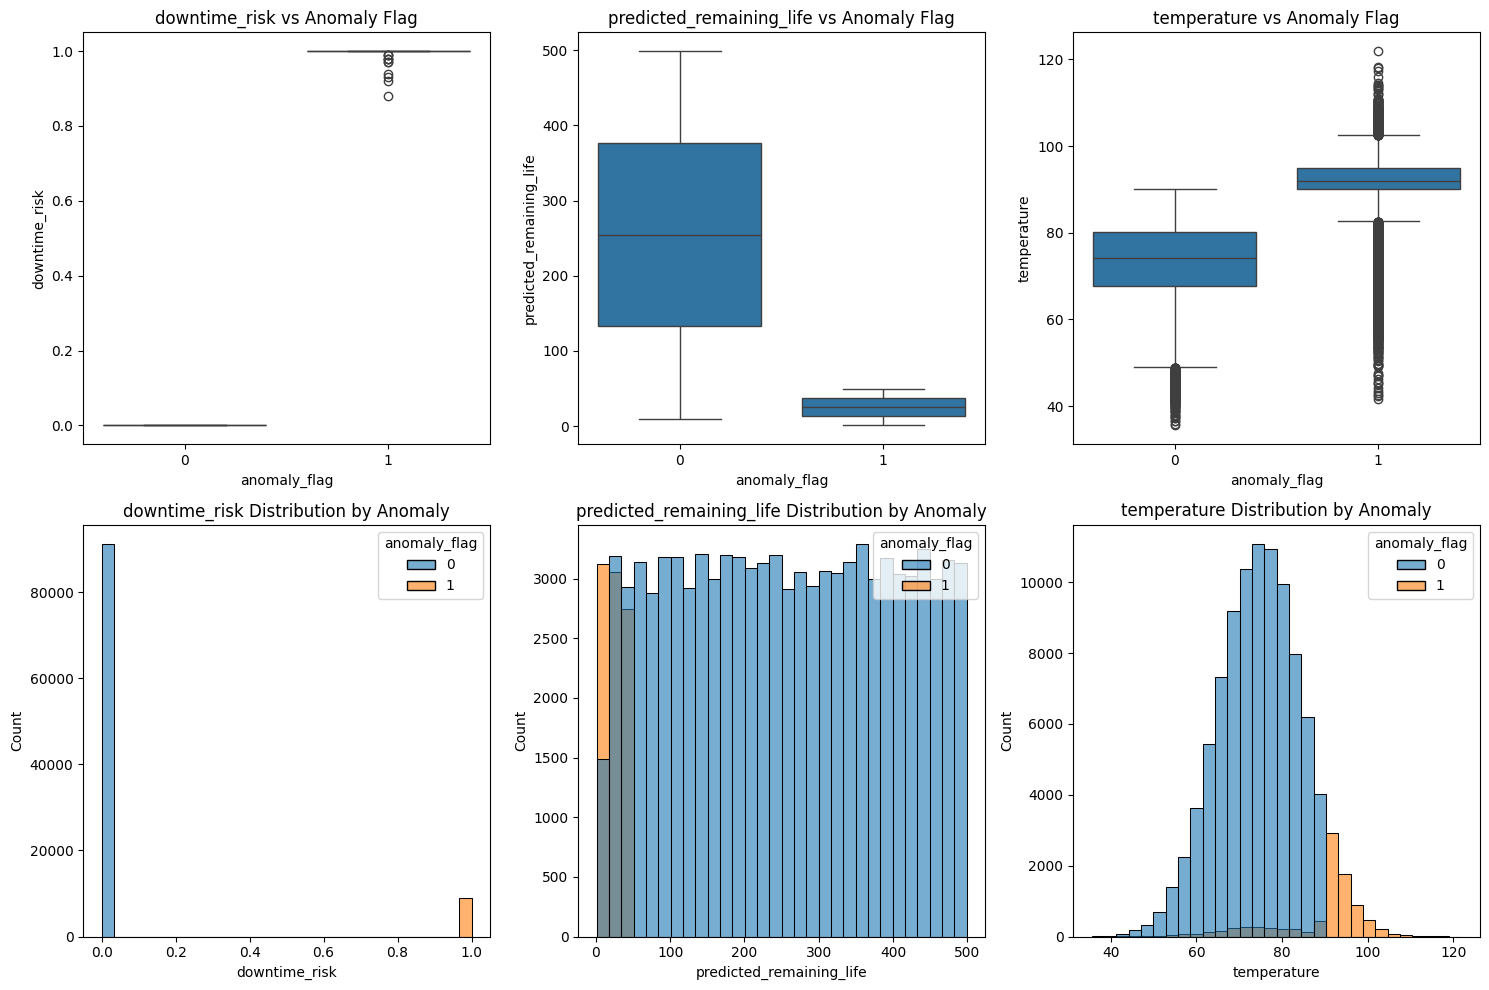

In [ ]:
# Feature Importance Analysis

from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between features and anomaly_flag
mi_scores = mutual_info_classif(X_scaled, y_true, random_state=42)

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'feature': selected_features,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("Feature Importances (Mutual Information):")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='mutual_info', y='feature', data=importance_df, palette='viridis')
plt.title('Feature Importances (Mutual Information)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

# Correlation with anomaly_flag
correlations = data[selected_features + ['anomaly_flag']].corr()['anomaly_flag'].drop('anomaly_flag').abs().sort_values(ascending=False)

print("\nCorrelation with anomaly_flag (absolute values):")
print(correlations)

# Plot correlations
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Feature Correlation with Anomaly Flag')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.show()

# Most important features
top_features = importance_df['feature'].tolist()
print(f"\nMost important features (by mutual information): {top_features}")

# Analyze relationship between top features and anomalies
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features[:3]):  # Plot top 3
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='anomaly_flag', y=feature, data=data)
    plt.title(f'{feature} vs Anomaly Flag')

    plt.subplot(2, 3, i+4)
    sns.histplot(data=data, x=feature, hue='anomaly_flag', alpha=0.6, bins=30)
    plt.title(f'{feature} Distribution by Anomaly')

plt.tight_layout()
plt.show()


**Feature Importances Bar Chart**: Shows how much each sensor feature helps detect anomalies. Higher bars mean the feature is more useful. Downtime risk is the most important, followed by predicted remaining life.

**Correlation Bar Chart**: Shows how strongly each feature relates to anomalies. Higher bars mean stronger connection. Again, downtime risk and predicted remaining life are most correlated with anomalies.

**Boxplots and Histograms**: For the top 3 features (downtime risk, predicted remaining life, energy consumption):
- Boxplots: Compare average values between normal (0) and anomaly (1) groups. Anomalies often have higher values.
- Histograms: Show value distributions, colored by normal/anomaly. Anomalies cluster at higher values for these features.

## Integration with API

The trained model is integrated with a FastAPI application for real-time anomaly detection. The API accepts sensor data and returns anomaly predictions.
In the next cell we will just simulate how the API works; what it needs as input and what it will return as response.

In [ ]:
# Demonstrate API usage

# Example sensor data for all 10 features used in training
test_data = {
    "temperature": 85.0,
    "vibration": 35.0,
    "humidity": 75.0,
    "energy_consumption": 450.0,
    "predicted_remaining_life": 85.0,
    "downtime_risk": 0.2,
}

print("Example API request:")
print("POST /predict")
print("Data:", test_data)

# Simulate API prediction 
# Create input array with the used features in the correct order
test_input = np.array([[
    test_data['temperature'],
    test_data['vibration'],
    test_data['humidity'],
    test_data['energy_consumption'],
    test_data['predicted_remaining_life'],
    test_data['downtime_risk'],
]])
test_scaled = scaler.transform(test_input)
anomaly_score = final_model.decision_function(test_scaled)[0] if hasattr(final_model, 'decision_function') else 0
is_anomaly = final_model.predict(test_scaled)[0] == -1

print("\nSimulated API response:")
print({
    "anomaly_score": anomaly_score,
    "is_anomaly": is_anomaly
})

print("\nTo run the actual API:")
print("1. python src/app.py")
print("2. Use the streaming script: python src/stream_data.py")
# if you run the API, you can send a POST request to the /predict endpoint with JSON data containing the sensor readings, and it will return whether the data point is an anomaly along with the anomaly score.
# Send a POST reqest to the API endpoint : 
# import requests
# response = requests.post("http://localhost:8000/predict", json=test_data)
# print("API Response:", response.json())

Example API request:
POST /predict
Data: {'temperature': 85.0, 'vibration': 35.0, 'humidity': 75.0, 'energy_consumption': 450.0, 'predicted_remaining_life': 85.0, 'downtime_risk': 0.2}

Simulated API response:
{'anomaly_score': np.float64(0.01804829394141738), 'is_anomaly': np.False_}

To run the actual API:
1. python src/app.py
2. Use the streaming script: python src/stream_data.py


d:\W\From Model to Production\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


API Response: {'anomaly_score': 0.01804829394141738, 'is_anomaly': False}


## Cloud Deployment (The Optional Step)
Hosting anomaly detection in the cloud is important for real projects because it enables scalability, remote access, reliability, easy updates, and secure integration with other systems.

In this section, I will guide you through the optional step to deploy the anomaly detection API to a cloud service using Docker and Microsoft Azure. This allows us to host the API in a scalable environment, making it accessible from anywhere.
We will use Docker to containerize the application and Azure App Service to host it.

### 1. Dockerization
- **Dockerfile**
  - Uses Python 3.9-slim.
  - Installs dependencies from `requirements.txt`.
  - Exposes port 8000 and runs the FastAPI app with Uvicorn.
- **Build & Test Locally**
  - Build: `docker build -t anomaly-api .`
  - Run: `docker run -p 8000:8000 anomaly-api`
  - Inspect: `docker run -it --rm anomaly-api sh` then `dir /app/models`

### 2. Azure Setup
- **Login & Prerequisites**
  - `az login`
  - Install Azure CLI: `choco install azure-cli`
- **Create Azure Container Registry (ACR)**
  - `az acr create --resource-group <RESOURCE_GROUP> --name <ACR_NAME> --sku Basic`
  - `az acr login --name <ACR_NAME>`
- **Push Docker Image to ACR**
  - Tag: `docker tag anomaly-api <ACR_NAME>.azurecr.io/anomaly-api:v1`
  - Push: `docker push <ACR_NAME>.azurecr.io/anomaly-api:v1`
- **Register Provider**
  - `az provider register --namespace Microsoft.Web`
- **Create App Service Plan**
  - `az appservice plan create --name <PLAN_NAME> --resource-group <RESOURCE_GROUP> --is-linux --sku F1 --location westeurope`
- **Enable Admin User on ACR**
  - `az acr update -n <ACR_NAME> --admin-enabled true`
- **Create Web App**
  - `az webapp create --resource-group <RESOURCE_GROUP> --plan <PLAN_NAME> --name <WEBAPP_NAME> --deployment-container-image-name <ACR_NAME>.azurecr.io/anomaly-api:v1`
- **Get Credentials**
  - `az acr credential show -n <ACR_NAME>`
  - Replace username, password, and email with `<ACR_USERNAME>`, `<ACR_PASSWORD>`, `<EMAIL>`
- **Configure Web App Container**
  - `az webapp config container set --name <WEBAPP_NAME> --resource-group <RESOURCE_GROUP> --container-image-name <ACR_NAME>.azurecr.io/anomaly-api:v1 --container-registry-url https://<ACR_NAME>.azurecr.io --container-registry-user <ACR_USERNAME> --container-registry-password <ACR_PASSWORD>`

### 3. Environment Variables Example
```json
[
  { "name": "WEBSITES_ENABLE_APP_SERVICE_STORAGE", "value": "false" },
  { "name": "DOCKER_REGISTRY_SERVER_URL", "value": "https://<ACR_NAME>.azurecr.io" },
  { "name": "DOCKER_REGISTRY_SERVER_USERNAME", "value": "<ACR_USERNAME>" },
  { "name": "DOCKER_REGISTRY_SERVER_PASSWORD", "value": "<ACR_PASSWORD>" },
  { "name": "DOCKER_CUSTOM_IMAGE_NAME", "value": "DOCKER|<ACR_NAME>.azurecr.io/anomaly-api:v1" }
]
```

### 4. Test the Cloud Endpoint
- Example request:
```bash
curl -X POST "https://<WEBAPP_NAME>.azurewebsites.net/predict" -H "Content-Type: application/json" -d '{"temperature":85.0,"vibration":35.0,"humidity":75.0,"energy_consumption":450.0,"predicted_remaining_life":85.0,"downtime_risk":0.2}'
```
- Example response:
```json
{"anomaly_score":0.01804829394141738,"is_anomaly":false}
```

### Cloud Dataset Storage (Azure Blob Storage)
To make the system fully cloud-based, we also store the dataset (`data.csv`) in Azure Blob Storage. This enables seamless integration, remote access, and easy updates to the data used for anomaly detection and retraining in case needed.

**Azure Blob Storage Steps:**
- **Create a Storage Account**
  - `az storage account create --name anomalydetectionstorage2 --resource-group AnomalyDetectionRG --location westeurope --sku Standard_LRS`
- **Create a Container**
  - `az storage container create --account-name anomalydetectionstorage2 --name datasets`
- **Upload the Dataset**
  - `az storage blob upload --account-name anomalydetectionstorage2 --container-name datasets --name data.csv --file Data/data.csv`
- **Get the Connection String**
  - `az storage account show-connection-string --name anomalydetectionstorage2 --resource-group AnomalyDetectionRG`
  - Output:
    ```json
    {
      "connectionString": "XXXX"
    }
    ```

In a real scenario, the dataset in Blob Storage would be updated with new sensor metrics, enabling periodic retraining of the model in case needed. For this demo, we simulate streaming metrics to the web app using a subset of the dataset stored in the cloud.

**To access the dataset from the stream script or API, use the storage account’s connection string and the container/blob name to read the CSV directly from Azure Blob Storage.** This approach ensures that the data pipeline is cloud native and scalable.

To test the streaming of data from Azure Blob Storage to the web app, please refer to the `stream_data.py` script in the `src` repository.



###  Some Screenshots

**Docker Desktop Running the Container**
![Docker Desktop](src/Cloud%20Implementation/Docker%20Desktop.png)

```json
{"anomaly_score":0.01804829394141738,"is_anomaly":false}
```

 **Exploring Docker Container**
![Exploring Docker Container](src/Cloud%20Implementation/exploring_docker_container.png)

 **Azure Portal: Web App Dashboard**
![Azure Web App Dashboard](src/Cloud%20Implementation/azure_web_app_dashboard.png)

 **Azure Endpoint Running**
![Azure Endpoint Running](src/Cloud%20Implementation/azure_endpoint_running.png)

**Successful API Response (Web App Prediction)**
![Web App Prediction](src/Cloud%20Implementation/web_app_prediction.png)

**Successful endpoint response from Azure Web App**
![Web App Prediction](src/Cloud%20Implementation/azure_endpoint_log_stream.png)
**Azure Blob Storage: Dataset Uploaded**
![Azure Blob Storage](src/Cloud%20Implementation/dataset_in_azure_blob_storage.png)
**Streaming data from Azure Blob Storage to Web App and receiving predictions from the azure web app endpoint**
![Streaming Data](src/Cloud%20Implementation/simulating_streaming_data_from_azure_blob_storage.png)

## Conclusion

This notebook has demonstrated the complete workflow for anomaly detection in an IoT setting  project, including significant performance improvements:

1. **Data Exploration**: Analyzed 100,000 IoT sensor readings with 8.92% anomalies, showing distributions and patterns.
2. **Preprocessing**: Selected 6 key features and normalized data for optimal model training.
3. **Model Training**: Trained and compared three anomaly detection algorithms (Isolation Forest, One-Class SVM, Local Outlier Factor).
4. **Evaluation**: Assessed models using precision, recall, F1-score, and confusion matrices.
5. **Model Selection**: Chose Isolation Forest as best performer with 95% F1-score for anomalies.
6. **Performance Improvement**: Achieved significant gains by iteratively refining features - from 46% F1 with 3 features to 65% with 10 features, finally settling on 6 optimal features.
7. **Feature Analysis**: Identified downtime_risk and predicted_remaining_life as most important predictors.
8. **Integration**: Demonstrated API integration for real-time anomaly detection.
9. **Cloud Deployment**: 
    - Containerized the API with Docker and deployed it to Microsoft Azure App Service for scalable, production-ready anomaly detection.
    - Uploaded the dataset to Azure Blob Storage, enabling the entire workflow (data, model, and API) to run fully in the cloud.
    - Simulated streaming sensor data from the cloud dataset to the API, as would occur in a real IoT production environment.


**Key Findings:**
- **Model Performance**: Isolation Forest excelled (F1: 0.95), One-Class SVM moderate (F1: 0.35), Local Outlier Factor poor (F1: 0.19)
- **Feature Impact**: Additional features like energy_consumption and maintenance indicators crucial for detection
- **Final Model**: Isolation Forest with 6 features achieves 95% anomaly detection accuracy
- **Practical Value**: Model ready for deployment in manufacturing IoT systems for predictive maintenance
- **Stream Processing Spotlight**: The API enables real-time stream processing of IoT sensor data, allowing immediate anomaly detection and alerts to prevent production issues.
- **Cloud Readiness**: The solution is fully containerized and deployable to Azure, enabling remote access, scalability, and easy integration with enterprise systems.


The improved model is now saved and ready for deployment in the FastAPI application for real-time anomaly detection in production cycles.